In [23]:
!git clone https://github.com/yusukeorito/my_lib.git

Cloning into 'my_lib'...
remote: Enumerating objects: 149, done.
remote: Counting objects: 100% (149/149), done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 149 (delta 67), reused 98 (delta 33), pack-reused 0
Receiving objects: 100% (149/149), 32.60 KiB | 252.00 KiB/s, done.
Resolving deltas: 100% (67/67), done.


## Setup

In [1]:
cd "/Users/oritoyusuke/Desktop/my_lib/"

/Users/oritoyusuke/Desktop/my_lib


In [2]:
import re
from IPython.lib import kernel

conn_file = kernel.get_connection_file().split('/')[-1]
kernel_id = re.findall('kernel-(.*)\.json', conn_file)[0]

In [3]:
import ipynb_path
__file__ = ipynb_path.get()
print(__file__)

/Users/oritoyusuke/Desktop/my_lib/Compe/experiments/Exp001.ipynb


In [4]:
import requests
import os
import sys
from typing import List, Tuple
from typing_extensions import Literal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
import catboost as cat

sys.path.append('.')
from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold
from sklearn.metrics import accuracy_score
from Compe.feature.base import AbstractBaseBlock, IdentityBlock, LabelEncodingBlock, OneHotEncodingBlock, AggBlock, run_blocks
from Compe.train.metric import AUC, Accuracy

In [5]:
def get_exp_name():
    return requests.get('http://172.28.0.2:9000/api/sessions').json()[0]['name'][:-6]

#各種フォルダ
COLAB = "/content/drive/MyDrive/"
OUTPUT = "/content/drive/output"
INPUT = "/content/drive/input"
SUBMISSION = os.path.join(COLAB, "submission")
EXP_NAME = get_exp_name() #file名を取得
EXP = os.path.join(OUTPUT, EXP_NAME)
PREDS = os.path.join(EXP, "preds")
TRAINED = os.path.join(EXP, "trainec")
FEATURES = os.path.join(EXP, "feature")
REPORTS = os.path.join(EXP, "reports")

dirs = [
    INPUT,
    OUTPUT,
    SUBMISSION,
    EXP,
    PREDS,
    TRAINED,
    FEATURES,
    REPORTS
]

for v in dirs:
    if not os.path.isdir(v):
        print(f"making {v}")
        os.makedirs(v)

ConnectionError: HTTPConnectionPool(host='172.28.0.2', port=9000): Max retries exceeded with url: /api/sessions (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x15f768ac0>: Failed to establish a new connection: [Errno 61] Connection refused'))

In [7]:
train = pd.read_csv('./Compe/Input/titanic/train.csv')
test = pd.read_csv('./Compe/Input/titanic/test.csv')

In [8]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [9]:
train.select_dtypes(int).columns

Index(['PassengerId', 'Survived', 'Pclass', 'SibSp', 'Parch'], dtype='object')

## FeatureEngineering

In [10]:
target = 'Survived'
num_cols = ['Age', 'Fare', 'Pclass', 'SibSp', 'Parch']
label_cols = ['Sex', 'Ticket', 'Cabin', 'Embarked']

In [11]:
first_blocks = [
    IdentityBlock(cols=num_cols),
    LabelEncodingBlock(cols = label_cols)
]

In [12]:
train_feat_df = run_blocks(
    train,
    blocks=first_blocks,
    test=False,
    new=False, # キャシュを更新するかどうか
    dataset_type="train",
    save_dir='./Compe/exp',
)

test_feat_df = run_blocks(
    test,
    blocks=first_blocks,
    test=True,
    new=False, # キャシュを更新するかどうか
    dataset_type="test",
   # save_dir=CFG.feature_dir,
)

★★★★★★★★★★★★★★★★★★★★ start run blocks... ★★★★★★★★★★★★★★★★★★★★
		- load dataet from Compe/exp/IdentityBlock/8d7a69c1cc1c10a49424c464f50521b6f0274509ee919cbdb2603f4c/train.pkl 0.003[s]
	- <Compe.feature.base.IdentityBlock object at 0x15f8d88b0> 0.004[s]
		- load dataet from Compe/exp/LabelEncodingBlock/651bc02be5ab9f520a4a204e6f34f0cac8b9146dd475c73abef45b07/train.pkl 0.001[s]
	- <Compe.feature.base.LabelEncodingBlock object at 0x15f8d86a0> 0.002[s]
Mem. usage decreased to 0.0Mb:  62% reduction
run test=False 0.018[s]
★★★★★★★★★★★★★★★★★★★★ start run blocks... ★★★★★★★★★★★★★★★★★★★★
		- load dataet from ../featurestore/IdentityBlock/8d7a69c1cc1c10a49424c464f50521b6f0274509ee919cbdb2603f4c/test.pkl 0.001[s]
	- <Compe.feature.base.IdentityBlock object at 0x15f8d88b0> 0.002[s]
		- load dataet from ../featurestore/LabelEncodingBlock/651bc02be5ab9f520a4a204e6f34f0cac8b9146dd475c73abef45b07/test.pkl 0.001[s]
	- <Compe.feature.base.LabelEncodingBlock object at 0x15f8d86a0> 0.001[s]
Mem. usage decre

In [13]:
train_X = train_feat_df.copy()
test_X = test_feat_df.copy()
train_y = train[target]

In [14]:
kf = KFold(n_splits=5, shuffle=True, random_state=2022)
task ="Binary"

## Model

### LightGBM

In [15]:
model_params_binary = {
    "boosting_type": "gbdt",

    
    "objective": "binary", 
    "metric":"binary_logloss", 

    "learning_rate": 0.05,
    "max_depth": 12,

    "reg_lambda": 1.,
    "reg_alpha": .1,

    "colsample_bytree": .5,
    "min_child_samples": 10,
    "subsample_freq": 3,
    "subsample": .8,

    "random_state": 2022,
    "verbose": -1,
    "n_jobs": 8,
    }


fit_params = {
    "num_boost_round": 10000,
    "early_stopping_rounds": 100,
    "verbose_eval": 100,
}

def fit_lgb(X:pd.DataFrame, y:pd.DataFrame,cv, model_params:dict,fit_params:dict, metric, fobj=None, feval=None):

    X, y = X.values, y.values

    """LightGBMをcross validationで学習"""
    models = []
    n_records = len(X)

    oof_pred = np.zeros((n_records, ), dtype=np.float)

    for i, (tr_idx, va_idx) in enumerate(cv.split(X, y)):
        tr_X, tr_y = X[tr_idx], y[tr_idx]
        va_X, va_y = X[va_idx], y[va_idx]

        train_data = lgb.Dataset(tr_X, label=tr_y)
        valid_data = lgb.Dataset(va_X, label=va_y)

        clf = lgb.train(
                model_params,
                train_data,
               **fit_params,
                valid_names=['train', 'valid'],
                valid_sets=[train_data, valid_data],
                feval=feval #自作の損失関数を適用
            )
        
       
        pred_i = clf.predict(va_X, num_iteration=clf.best_iteration)
        oof_pred[va_idx] = pred_i
        models.append(clf)

        score = metric(va_y, pred_i)
        print(f" - fold{i+1} score - {score:.4f}")

   
    score = metric(y, oof_pred)
    print(f"OOF score - {score:.4f}")   
    return oof_pred, models

def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.
    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        # _df["feature_importance"] = model.feature_importances_
        _df["feature_importance"] = model.feature_importance(importance_type="gain")
        _df["column"] = feat_train_df.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby("column")\
        .sum()[["feature_importance"]]\
        .sort_values("feature_importance", ascending=False).index[:50]#上位50個を表示

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x="feature_importance", 
                  y="column", 
                  order=order, 
                  ax=ax, 
                  palette="viridis", 
                  orient="h")
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax

def predict_lgb(models, test_X:pd.DataFrame):
    preds = np.array([model.predict(test_X) for model in models])
    pred = np.mean(preds, axis=0) 
    return pred

def make_sub(sub:pd.DataFrame, pred:np.ndarray, Path):
    sub['prediction'] = pred
    sub.to_csv(Path)

In [16]:
lgb_oof, lgb_models = fit_lgb(train_X, train_y, cv=kf, model_params=model_params_binary, fit_params=fit_params, metric=Accuracy)

/var/folders/nm/f1mftswx2bn4x3l5cmqskq5r0000gn/T/ipykernel_93223/1480744456.py:39: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  oof_pred = np.zeros((n_records, ), dtype=np.float)


Training until validation scores don't improve for 100 rounds
[100]	train's binary_logloss: 0.229983	valid's binary_logloss: 0.433185
[200]	train's binary_logloss: 0.140798	valid's binary_logloss: 0.438524
Early stopping, best iteration is:
[117]	train's binary_logloss: 0.21127	valid's binary_logloss: 0.427028
 - fold1 score - 0.8156
Training until validation scores don't improve for 100 rounds
[100]	train's binary_logloss: 0.218928	valid's binary_logloss: 0.488927
Early stopping, best iteration is:
[73]	train's binary_logloss: 0.26484	valid's binary_logloss: 0.475901
 - fold2 score - 0.7753
Training until validation scores don't improve for 100 rounds
[100]	train's binary_logloss: 0.229009	valid's binary_logloss: 0.46418
Early stopping, best iteration is:
[67]	train's binary_logloss: 0.284235	valid's binary_logloss: 0.456098
 - fold3 score - 0.8034
Training until validation scores don't improve for 100 rounds
[100]	train's binary_logloss: 0.25161	valid's binary_logloss: 0.337692
[200]

### Catboost

In [17]:
model_params_binary = {
    "task_type": "CPU",
    "num_boost_round": 10000,

    "loss_function": "Logloss",
    "eval_metric":"AUC", 

    "learning_rate": 0.05,
    "depth": 6,


    "random_state": 2022,
    }

cat_fit_params = {
    "early_stopping_rounds": 100,
    "verbose": 100,
}


def fit_cat(X:pd.DataFrame, y:pd.DataFrame,cv, model_params:dict,fit_params:dict, metric, 
categorical_list:List[str]=None,task:Literal["Regression", "Binary", "Multiclass"]=None, fobj=None,):

    X, y = X.values, y.values

    """LightGBMをcross validationで学習"""
    models = []
    n_records = len(X)
    oof_pred = np.zeros((n_records, ), dtype=np.float)

    for i, (tr_idx, va_idx) in enumerate(cv.split(X, y)):
        tr_X, tr_y = X[tr_idx], y[tr_idx]
        va_X, va_y = X[va_idx], y[va_idx]

        train_data = cat.Pool(tr_X, label=tr_y)
        valid_data = cat.Pool(va_X, label=va_y)

        if task=="Regression":
            model = cat.CatBoostRegressor(**model_params)
        elif task=="Binary" or task=="Multiclass":
            model = cat.CatBoostClassifier(**model_params)
        else:
            raise ValueError

        model.fit(
            train_data,
            **fit_params,
            plot=False,
            use_best_model=True,
            eval_set=[valid_data],
        )

        if task=="Regression":
            pred_i = model.predict(va_X)
        elif task == "Binary":
            pred_i = model.predict(va_X, prediction_type="Probability")[:, 1]
        elif task == "Multiclass":
            pred_i =  model.predict(va_X, prediction_type="Probability")
        else:
            raise ValueError
        

        oof_pred[va_idx] = pred_i
        models.append(model)

        score = metric(va_y, pred_i)
        print(f" - fold{i+1} score - {score:.4f}")

   
    score = metric(y, oof_pred)
    print(f"OOF score - {score:.4f}")   
    return oof_pred, models

def predict_cat(models, test_X:pd.DataFrame,task:Literal["Regression", "Binary", "Multiclass"]):
    if task=="Regression":
        preds = np.array([model.predict(test_X) for model in models])
        pred = np.mean(preds, axis=0) 
    elif task == "Binary":
        preds = np.array([model.predict(test_X, prediction_type="Probability")[:,1] for model in models])
        pred = np.mean(preds, axis=0) #確率の平均値を算出
    elif task == "Multiclass":
        preds = np.array([model.predict(test_X, prediction_type="Probability") for model in models])
        pred = np.mean(preds, axis=0) #クラスごとに確率の平均値を算出
    return pred

In [18]:
cat_oof, cat_models = fit_cat(train_X, train_y, cv=kf, task="Binary",
                              model_params=model_params_binary, fit_params=cat_fit_params, metric=Accuracy)

/var/folders/nm/f1mftswx2bn4x3l5cmqskq5r0000gn/T/ipykernel_93223/2516484693.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  oof_pred = np.zeros((n_records, ), dtype=np.float)


0:	test: 0.8273279	best: 0.8273279 (0)	total: 61ms	remaining: 10m 9s
100:	test: 0.8639676	best: 0.8709852 (48)	total: 155ms	remaining: 15.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8709851552
bestIteration = 48

Shrink model to first 49 iterations.
 - fold1 score - 0.8045
0:	test: 0.8253999	best: 0.8253999 (0)	total: 1.17ms	remaining: 11.7s
100:	test: 0.8444272	best: 0.8542957 (2)	total: 67.4ms	remaining: 6.61s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8542956656
bestIteration = 2

Shrink model to first 3 iterations.
 - fold2 score - 0.8034
0:	test: 0.8096414	best: 0.8096414 (0)	total: 428us	remaining: 4.29s
100:	test: 0.8525208	best: 0.8557692 (96)	total: 66ms	remaining: 6.47s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8557692308
bestIteration = 96

Shrink model to first 97 iterations.
 - fold3 score - 0.7697
0:	test: 0.8442982	best: 0.8442982 (0)	total: 1.26ms	remaining: 12.6s
100:	test: 0.9243421	best:

In [20]:
lgb_pred =  predict_lgb(lgb_models, test_X)

In [21]:
cat_pred =  predict_cat(cat_models, test_X,task="Binary")

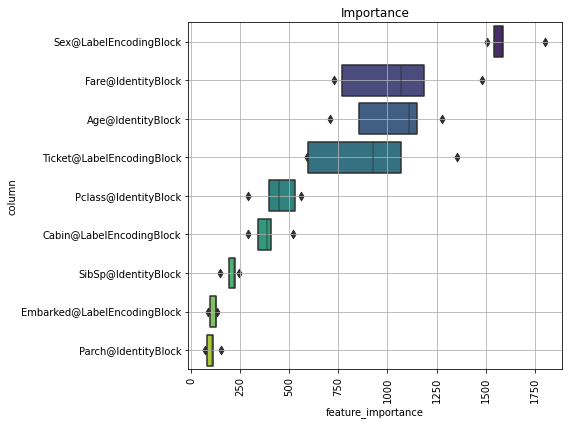

In [22]:
_ = visualize_importance(lgb_models, train_X)

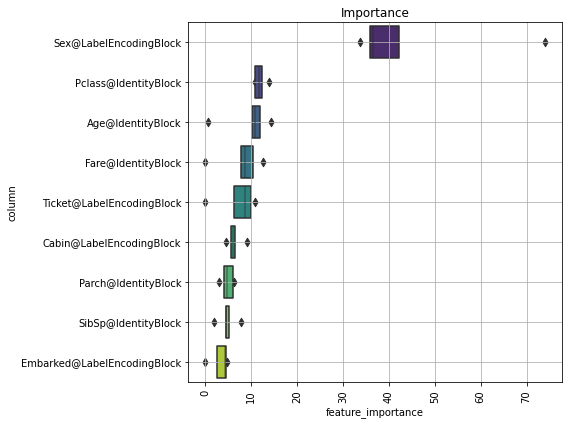

In [25]:
_ = visualize_importance_cat(cat_models, train_X)

In [55]:
cat_models[0].get_feature_importance(cat.Pool(train_X,train_y), type="PredictionValuesChange")

array([10.22052277,  7.80892654, 13.89900747,  5.23503659,  6.20672229,
       42.290343  ,  6.20676248,  5.50848239,  2.62419646])

In [24]:
def visualize_importance_cat(models, feat_train_df):
    """Catboost の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.
    args:
        models:
            List of Catboost models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.get_feature_importance(cat.Pool(train_feat_df), type="PredictionValuesChange")
        _df["column"] = feat_train_df.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby("column")\
        .sum()[["feature_importance"]]\
        .sort_values("feature_importance", ascending=False).index[:50]#上位50個を表示

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x="feature_importance", 
                  y="column", 
                  order=order, 
                  ax=ax, 
                  palette="viridis", 
                  orient="h")
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax